In [280]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import seaborn as sns

# Exploratory Data Analysis - Pittsburgh Penguins 2015-2016 Playoff Data
## 2015-2016 Stanley Cup Winners
--------
### To begin the EDA process, I use the SQL query below to quickly get the data I'm looking for.
* game type 'P' = Playoff Game
* Penguins team id = 5
### After creating the query, I connected to the NHL_data database and created a pandas df for easier manipulation and analysis.


In [281]:
playoff_20152016_data_query = ('''
SELECT game.game_id, game_plays.*, game_plays_players.player_id, player_info.firstName, player_info.lastName FROM game
JOIN game_plays ON game.game_id = game_plays.game_id
JOIN game_plays_players ON game_plays.play_id = game_plays_players.play_id
JOIN player_info ON game_plays_players.player_id = player_info.player_id
WHERE game.type = 'P'
    AND game.season = 20152016
    AND (
        game.home_team_id = 5
        OR
        game.away_team_id = 5
        );
''')

In [282]:
conn = sqlite3.connect('NHL_data.db')

In [283]:
pens_201516_playoff_df = pd.read_sql_query(playoff_20152016_data_query, conn)

In [284]:
pens_201516_playoff_df.head()

,game_id,play_id,game_id,team_id_for,team_id_against,event,secondaryType,x,y,period,...,periodTimeRemaining,dateTime,goals_away,goals_home,description,st_x,st_y,player_id,firstName,lastName
0,2015030141,2015030141_10,2015030141,3.0,5.0,Hit,None,-96.0,31.0,1,...,1098.0,2016-04-14 01:12:35,0,0,Jesper Fast hit Olli Maatta,96.0,-31.0,8475855,Jesper,Fast
1,2015030141,2015030141_10,2015030141,3.0,5.0,Hit,None,-96.0,31.0,1,...,1098.0,2016-04-14 01:12:35,0,0,Jesper Fast hit Olli Maatta,96.0,-31.0,8476874,Olli,Maatta
2,2015030141,2015030141_100,2015030141,3.0,5.0,Hit,None,-98.0,30.0,1,...,222.0,2016-04-14 01:44:19,0,0,Jesper Fast hit Carl Hagelin,98.0,-30.0,8474176,Carl,Hagelin
3,2015030141,2015030141_100,2015030141,3.0,5.0,Hit,None,-98.0,30.0,1,...,222.0,2016-04-14 01:44:19,0,0,Jesper Fast hit Carl Hagelin,98.0,-30.0,8475855,Jesper,Fast
4,2015030141,2015030141_101,2015030141,3.0,5.0,Hit,None,-89.0,-37.0,1,...,215.0,2016-04-14 01:44:26,0,0,Jesper Fast hit Justin Schultz,89.0,37.0,8474602,Justin,Schultz


The query was quick and easy, but seems to have given some repetitive data. To confirm, I checked the columns:

In [285]:
pens_201516_playoff_df.columns

Index(['game_id', 'play_id', 'game_id', 'team_id_for', 'team_id_against',
       'event', 'secondaryType', 'x', 'y', 'period', 'periodType',
       'periodTime', 'periodTimeRemaining', 'dateTime', 'goals_away',
       'goals_home', 'description', 'st_x', 'st_y', 'player_id', 'firstName',
       'lastName'],
      dtype='object')

As expected, some columns are the same. Also noticeable is how there is both an x, y and a st_x, st_y. Only one set of coordinates is needed. 
Below I drop any duplicated columns, as well as any additional columns that are unnecessary at this time.

In [286]:
pens_201516_playoff_df = pens_201516_playoff_df.iloc[:,~pens_201516_playoff_df.columns.duplicated()]

In [287]:
pens_201516_playoff_df = pens_201516_playoff_df.drop(['dateTime','st_x','st_y'], axis=1)

I'd like to see what we're looking at for event, secondaryType, and periodType:

In [288]:
pens_201516_playoff_df.event.unique()

array(['Hit', 'Shot', 'Faceoff', 'Blocked Shot', 'Missed Shot',
       'Takeaway', 'Goal', 'Penalty', 'Giveaway'], dtype=object)

In [289]:
pens_201516_playoff_df.secondaryType.unique()

array([None, 'Wrist Shot', 'Snap Shot', 'Slap Shot', 'Interference',
       'Backhand', 'Holding', 'Tripping', 'Tip-In',
       'Hi stick - double minor', 'Roughing', 'Interference - Goalkeeper',
       'Wrap-around', 'Hooking', 'Illegal check to head',
       'Unsportsmanlike conduct', 'Slashing', 'Cross checking',
       'Fighting', 'Boarding', 'Holding the stick', 'Hi-sticking',
       'Embellishment', 'Too many men on the ice',
       'Delaying Game - Puck over glass', 'Elbowing', 'Misconduct',
       'Deflected'], dtype=object)

In [290]:
pens_201516_playoff_df.periodType.unique()

array(['REGULAR', 'OVERTIME'], dtype=object)

Next, I want to check for null values in the df:

In [291]:
pens_201516_playoff_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13179 entries, 0 to 13178
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   game_id              13179 non-null  int64  
 1   play_id              13179 non-null  object 
 2   team_id_for          13179 non-null  float64
 3   team_id_against      13179 non-null  float64
 4   event                13179 non-null  object 
 5   secondaryType        3586 non-null   object 
 6   x                    13163 non-null  float64
 7   y                    13165 non-null  float64
 8   period               13179 non-null  int64  
 9   periodType           13179 non-null  object 
 10  periodTime           13179 non-null  int64  
 11  periodTimeRemaining  13179 non-null  float64
 12  goals_away           13179 non-null  int64  
 13  goals_home           13179 non-null  int64  
 14  description          13179 non-null  object 
 15  player_id            13179 non-null 

Secondary type is the only column that contains null values. What percent are null? Is this column worth keeping?

In [292]:
secondary_type_percent_null = (pens_201516_playoff_df['secondaryType'].isnull().sum())/13179*100
secondary_type_percent_null

72.79004476819182

In [293]:
pens_201516_playoff_df[pens_201516_playoff_df['event']=='Penalty']

,game_id,play_id,team_id_for,team_id_against,event,secondaryType,x,y,period,periodType,periodTime,periodTimeRemaining,goals_away,goals_home,description,player_id,firstName,lastName
62,2015030141,2015030141_136,3.0,5.0,Penalty,Interference,84.0,-19.0,2,REGULAR,9,1191.0,0,1,Chris Kreider Interference against Kris Letang,8471724,Kris,Letang
63,2015030141,2015030141_136,3.0,5.0,Penalty,Interference,84.0,-19.0,2,REGULAR,9,1191.0,0,1,Chris Kreider Interference against Kris Letang,8475184,Chris,Kreider
153,2015030141,2015030141_193,3.0,5.0,Penalty,Holding,-74.0,-39.0,2,REGULAR,602,598.0,0,1,Dominic Moore Holding against Tom Kuhnhackl,8468575,Dominic,Moore
154,2015030141,2015030141_193,3.0,5.0,Penalty,Holding,-74.0,-39.0,2,REGULAR,602,598.0,0,1,Dominic Moore Holding against Tom Kuhnhackl,8475832,Tom,Kuhnhackl
168,2015030141,2015030141_202,5.0,3.0,Penalty,Tripping,80.0,-13.0,2,REGULAR,706,494.0,0,1,Trevor Daley Tripping against Rick Nash,8470041,Rick,Nash
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13010,2015030416,2015030416_329,28.0,5.0,Penalty,Slashing,-35.0,11.0,3,REGULAR,662,538.0,2,1,Brent Burns Slashing against Phil Kessel,8473548,Phil,Kessel
13069,2015030416,2015030416_369,5.0,28.0,Penalty,Hi-sticking,32.0,4.0,3,REGULAR,1190,10.0,3,1,Eric Fehr Hi-sticking against Joe Pavelski,8470611,Eric,Fehr
13070,2015030416,2015030416_369,5.0,28.0,Penalty,Hi-sticking,32.0,4.0,3,REGULAR,1190,10.0,3,1,Eric Fehr Hi-sticking against Joe Pavelski,8470794,Joe,Pavelski
13094,2015030416,2015030416_51,28.0,5.0,Penalty,Tripping,-44.0,36.0,1,REGULAR,470,730.0,0,0,Dainius Zubrus Tripping against Brian Dumoulin,8464977,Dainius,Zubrus


In [294]:
pens_201516_playoff_df[pens_201516_playoff_df['event']=='Shot']

,game_id,play_id,team_id_for,team_id_against,event,secondaryType,x,y,period,periodType,periodTime,periodTimeRemaining,goals_away,goals_home,description,player_id,firstName,lastName
10,2015030141,2015030141_104,3.0,5.0,Shot,Wrist Shot,-80.0,6.0,1,REGULAR,997,203.0,0,0,Eric Staal Wrist Shot saved by Jeff Zatkoff,8470595,Eric,Staal
11,2015030141,2015030141_104,3.0,5.0,Shot,Wrist Shot,-80.0,6.0,1,REGULAR,997,203.0,0,0,Eric Staal Wrist Shot saved by Jeff Zatkoff,8473553,Jeff,Zatkoff
14,2015030141,2015030141_107,5.0,3.0,Shot,Wrist Shot,34.0,21.0,1,REGULAR,1005,195.0,0,0,Tom Kuhnhackl Wrist Shot saved by Henrik Lundq...,8468685,Henrik,Lundqvist
15,2015030141,2015030141_107,5.0,3.0,Shot,Wrist Shot,34.0,21.0,1,REGULAR,1005,195.0,0,0,Tom Kuhnhackl Wrist Shot saved by Henrik Lundq...,8475832,Tom,Kuhnhackl
18,2015030141,2015030141_109,5.0,3.0,Shot,Wrist Shot,54.0,-33.0,1,REGULAR,1014,186.0,0,0,Eric Fehr Wrist Shot saved by Henrik Lundqvist,8468685,Henrik,Lundqvist
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13161,2015030416,2015030416_9,5.0,28.0,Shot,Slap Shot,-34.0,-31.0,1,REGULAR,59,1141.0,0,0,Olli Maatta Slap Shot saved by Martin Jones,8476874,Olli,Maatta
13169,2015030416,2015030416_95,5.0,28.0,Shot,Wrist Shot,-61.0,-3.0,1,REGULAR,989,211.0,1,0,Sidney Crosby Wrist Shot saved by Martin Jones,8471675,Sidney,Crosby
13170,2015030416,2015030416_95,5.0,28.0,Shot,Wrist Shot,-61.0,-3.0,1,REGULAR,989,211.0,1,0,Sidney Crosby Wrist Shot saved by Martin Jones,8474889,Martin,Jones
13173,2015030416,2015030416_97,5.0,28.0,Shot,Wrist Shot,-86.0,9.0,1,REGULAR,994,206.0,1,0,Sidney Crosby Wrist Shot saved by Martin Jones,8471675,Sidney,Crosby


After seeing that 73% of secondaryType rows are NULL, I was initially tempted to drop the column entirely.
However, after taking a look at what the unique values are it occured to me that the entries mostly correspond with Shots and Penalties.
Because this information could be very useful, I want to keep the column for now.

### What now? What am I looking for?
I'm curious about the plays and player stats for the 3rd Line. 
For the Playoffs, this was: Carl Hagelin, Nick Bonino, and Phil Kessel (well-known as the 'HBK line')

In [295]:
HBK_line_201516_playoff_df = pens_201516_playoff_df[pens_201516_playoff_df['lastName'].isin(['Hagelin','Bonino','Kessel'])]
HBK_line_201516_playoff_df.head()

,game_id,play_id,team_id_for,team_id_against,event,secondaryType,x,y,period,periodType,periodTime,periodTimeRemaining,goals_away,goals_home,description,player_id,firstName,lastName
2,2015030141,2015030141_100,3.0,5.0,Hit,None,-98.0,30.0,1,REGULAR,978,222.0,0,0,Jesper Fast hit Carl Hagelin,8474176,Carl,Hagelin
9,2015030141,2015030141_103,5.0,3.0,Hit,None,-48.0,40.0,1,REGULAR,992,208.0,0,0,Carl Hagelin hit Kevin Klein,8474176,Carl,Hagelin
21,2015030141,2015030141_11,5.0,3.0,Shot,Snap Shot,45.0,-19.0,1,REGULAR,115,1085.0,0,0,Phil Kessel Snap Shot saved by Henrik Lundqvist,8473548,Phil,Kessel
35,2015030141,2015030141_12,5.0,3.0,Hit,None,-13.0,37.0,1,REGULAR,121,1079.0,0,0,Phil Kessel hit Kevin Hayes,8473548,Phil,Kessel
71,2015030141,2015030141_141,5.0,3.0,Missed Shot,None,-61.0,35.0,2,REGULAR,41,1159.0,0,1,Phil Kessel - Wide of Net,8473548,Phil,Kessel


In [296]:
def plotHockeyPoints(data, event_filter):
    scatter_data = HBK_line_201516_playoff_df.loc[(HBK_line_201516_playoff_df['event']== event_filter)]
    xpoints = np.array(scatter_data['x'])
    ypoints = np.array(scatter_data['y'])
    fig = sns.scatterplot(x=xpoints, y=ypoints, data= scatter_data, hue='lastName', size= 'lastName')
    plt.title(f'Location of {event_filter}s 2015 HBK Line')
    plt.xlabel=None
    plt.ylabel=None
    fig.set(xticklabels=[])
    fig.set(yticklabels=[])
    fig.grid(False)
    plt.show()
    plt.close()


In [297]:
events = HBK_line_201516_playoff_df.event.unique()
type(events)

numpy.ndarray

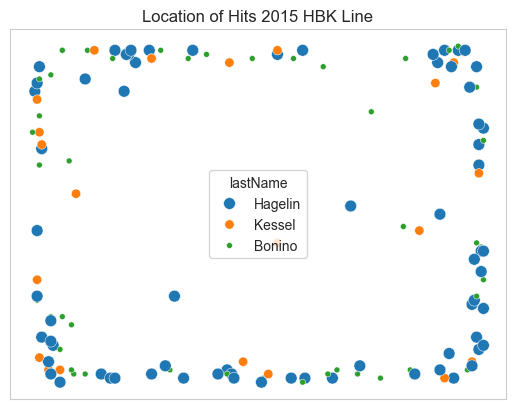

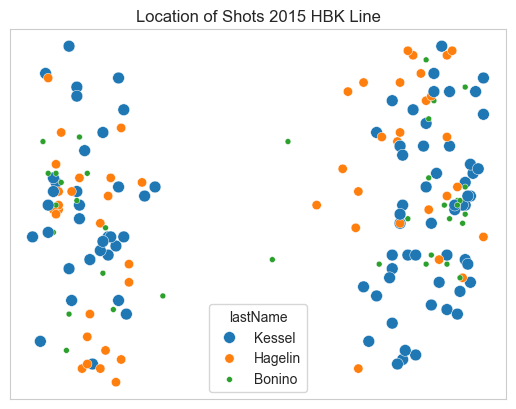

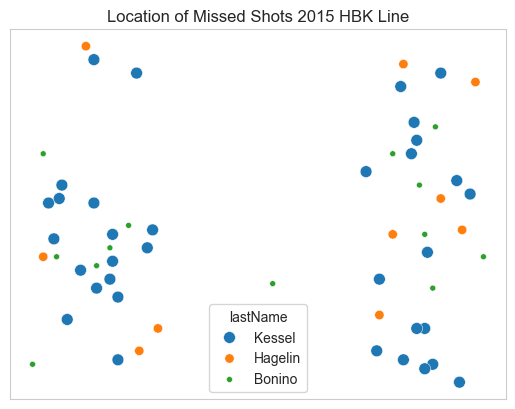

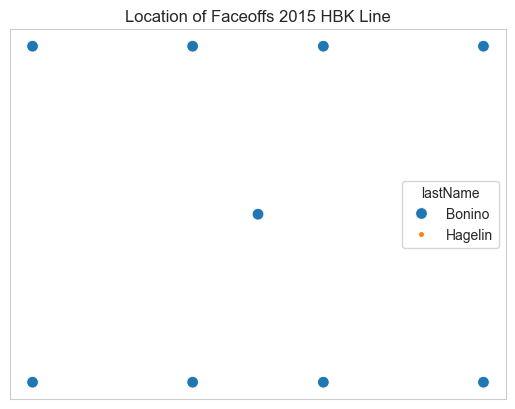

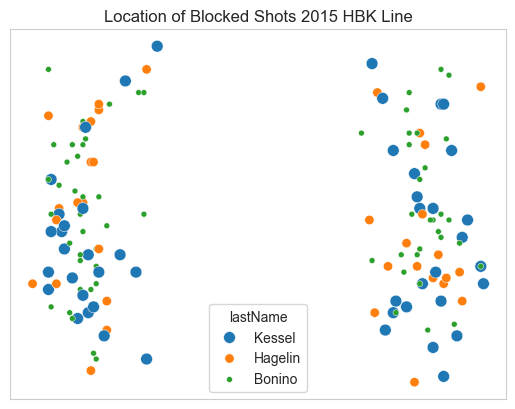

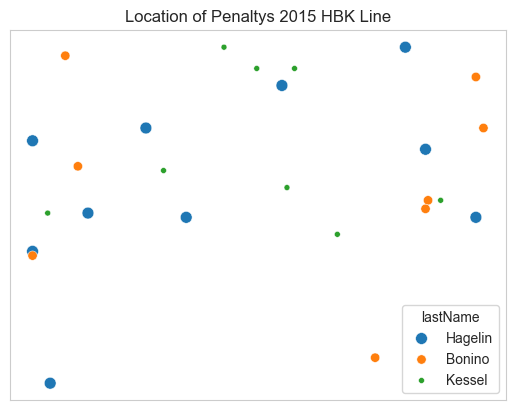

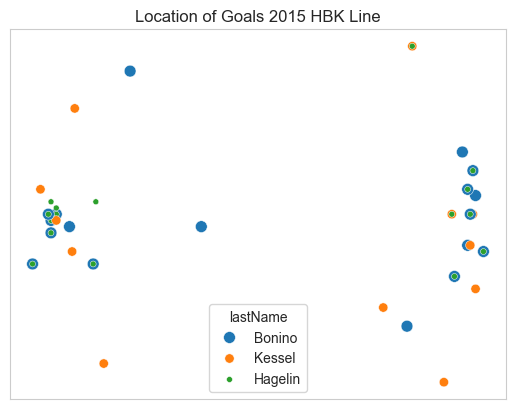

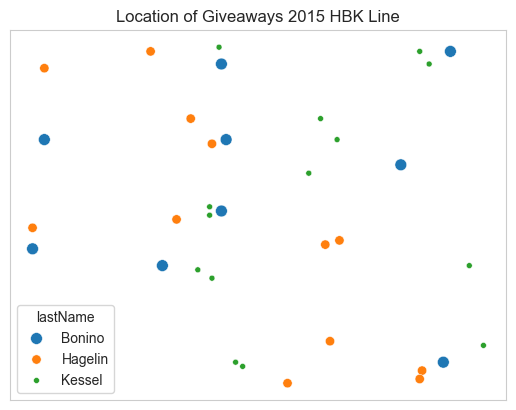

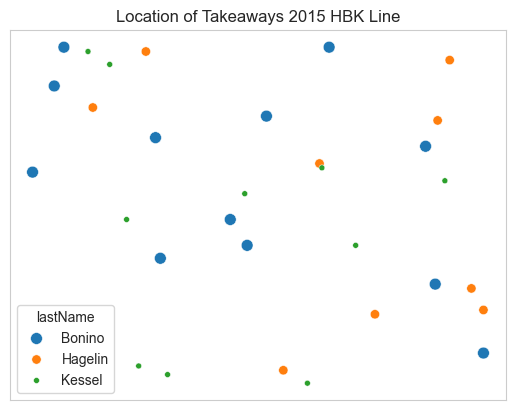

In [298]:
for event in events:
    plotHockeyPoints(HBK_line_201516_playoff_df, event)

In [299]:
create_skater_stats_query = ('''
SELECT skater_stats.*
FROM (
    SELECT game_skater_stats.*,
       player_info.firstName,
       player_info.lastName
FROM game_skater_stats
JOIN player_info ON game_skater_stats.player_id = player_info.player_id) skater_stats

LEFT JOIN game ON skater_stats.game_id = game.game_id
WHERE game.season = 20152016
    AND game.type = 'P'
    AND skater_stats.team_id = 5;
''')

In [300]:
pens_201516_playoff_skater_stats_df = pd.read_sql_query(create_skater_stats_query,conn)

In [301]:
pens_201516_playoff_skater_stats_df.head()

,game_id,player_id,team_id,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,...,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,shortHandedTimeOnIce,powerPlayTimeOnIce,firstName,lastName
0,2015030141,8474602,5,352,0,0,1,0.0,0,0,...,1.0,0,0,1.0,0,262,0,90,Justin,Schultz
1,2015030141,8471675,5,1270,2,1,2,1.0,0,1,...,2.0,0,0,0.0,3,825,14,431,Sidney,Crosby
2,2015030141,8477839,5,642,1,0,2,0.0,0,0,...,0.0,0,0,2.0,2,546,0,96,Conor,Sheary
3,2015030141,8473933,5,976,0,0,1,3.0,0,0,...,0.0,0,0,2.0,0,734,238,4,Ben,Lovejoy
4,2015030141,8474009,5,1068,1,0,1,2.0,0,0,...,1.0,0,1,3.0,1,747,261,60,Nick,Bonino


In [302]:
pens_201516_playoff_skater_stats_df = pens_201516_playoff_skater_stats_df.drop(['player_id','team_id'], axis=1)

In [412]:
players_sums_df = pens_201516_playoff_skater_stats_df.groupby('lastName').aggregate({'goals':'sum', 'assists':'sum', 'plusMinus':'sum', 'hits':'sum', 'game_id':'count', 'timeOnIce':'mean'}).reset_index()
players_sums_df = players_sums_df[players_sums_df['game_id']>15]
players_sums_df


,lastName,goals,assists,plusMinus,hits,game_id,timeOnIce
1,Bonino,4,14,9,16.0,24,1032.041667
2,Cole,1,2,6,49.0,24,972.750000
3,Crosby,6,13,-2,32.0,24,1226.333333
4,Cullen,4,2,3,25.0,24,829.791667
6,Dumoulin,2,6,-3,34.0,24,1291.458333
7,Fehr,3,1,-1,49.0,23,698.913043
8,Hagelin,6,10,9,41.0,24,982.958333
9,Hornqvist,9,4,-5,88.0,24,1042.500000
10,Kessel,10,12,5,9.0,24,1066.958333
11,Kuhnhackl,2,3,1,63.0,24,658.708333


Text(0.5, 1.0, 'Total Goals vs. Time on Ice')

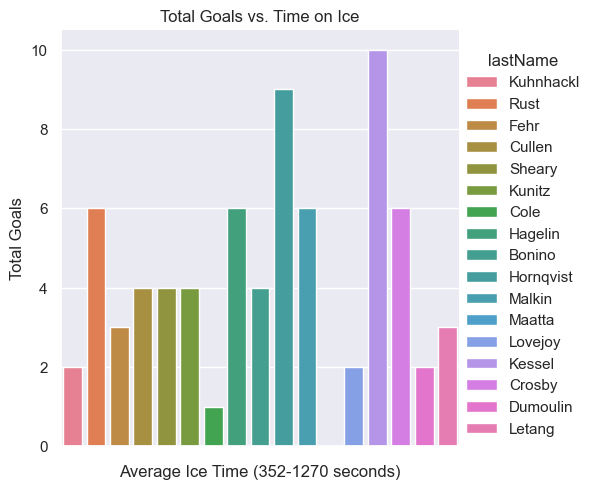

In [413]:
fig = sns.catplot(data= players_sums_df, x='timeOnIce',y='goals',hue='lastName',kind='bar')
fig.set_axis_labels('Average Ice Time (352-1270 seconds)', 'Total Goals')
fig.set(xticklabels=[])
plt.title('Total Goals vs. Time on Ice')


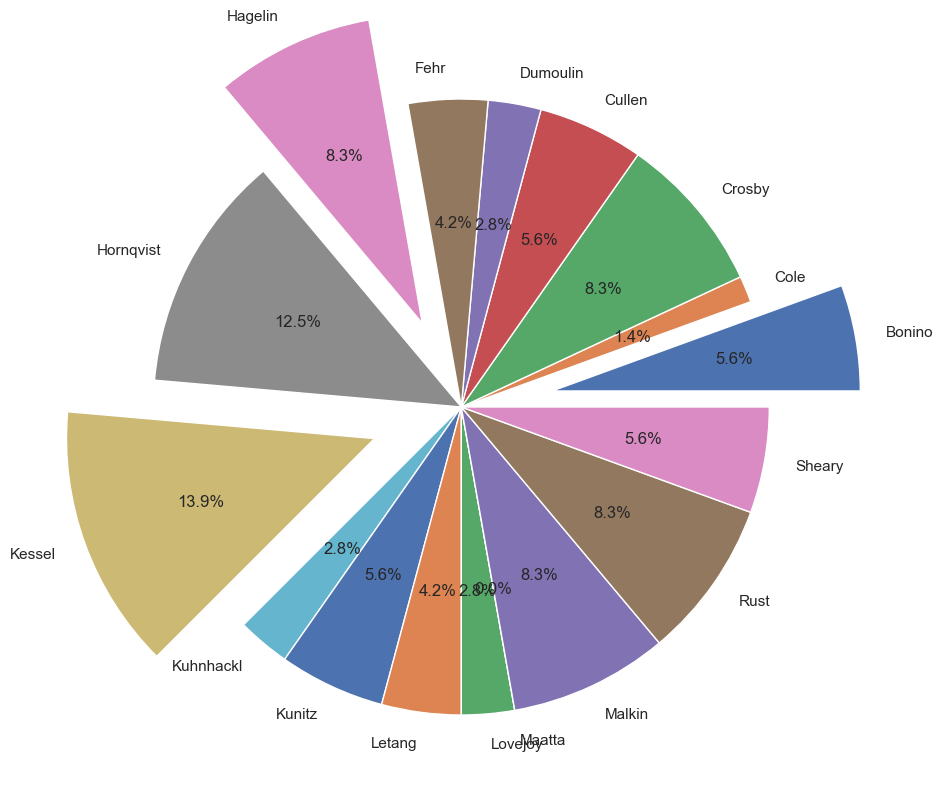

In [426]:
labels = players_sums_df['lastName']
#colors = ['lightblue', 'beige', 'lightgreen', 'orange', 'cyan', 'magenta','yellow','lightblue', 'beige', 'lightgreen', 'orange', 'cyan', 'magenta','yellow','lightblue', 'beige', 'lightgreen']
explode = [0.3,0,0,0,0,0,0.3,0,0.3,0,0,0,0,0,0,0,0]
sizes = players_sums_df['goals']

plt.figure(0,figsize = (10,10))
plt.pie(sizes, labels=labels, explode = explode, autopct='%1.1f%%')
plt.show()

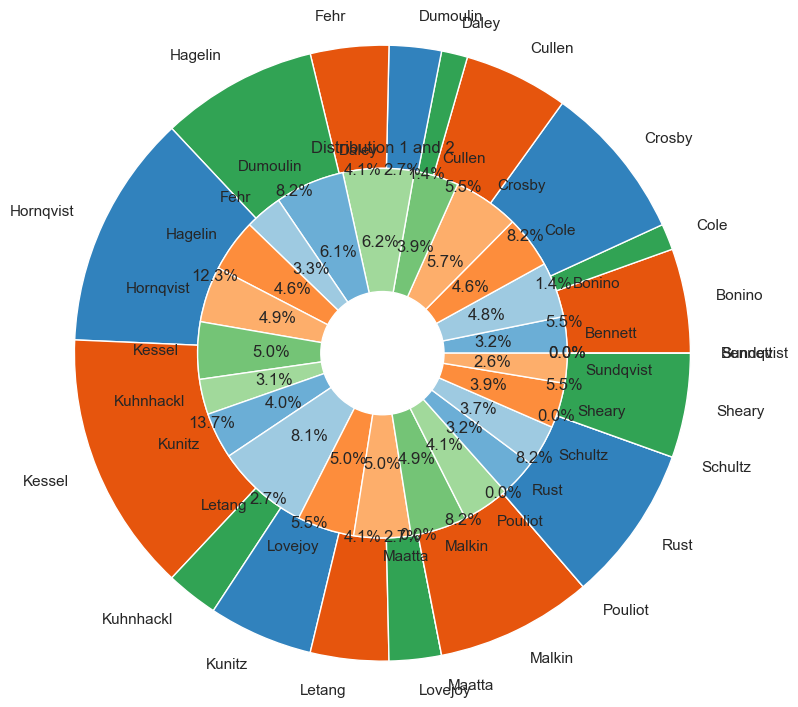

In [398]:

fig, ax = plt.subplots()

size = 0.8
vals = np.array([[60., 32.], [37., 40.], [29., 10.]])

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(3)*4)
inner_colors = cmap(np.array([1, 2, 5, 6, 9, 10]))

ax.pie(players_sums_df['goals'], radius=2, colors=outer_colors, labels=players_sums_df['lastName'], autopct='%1.1f%%',
       wedgeprops=dict(width=size, edgecolor='w'))

ax.pie(players_sums_df['timeOnIce'], radius=2-size, colors=inner_colors, labels=players_sums_df['lastName'], autopct='%1.1f%%',
       wedgeprops=dict(width=size, edgecolor='w'))

ax.set(aspect="equal", title='Distribution 1 and 2')
plt.show()

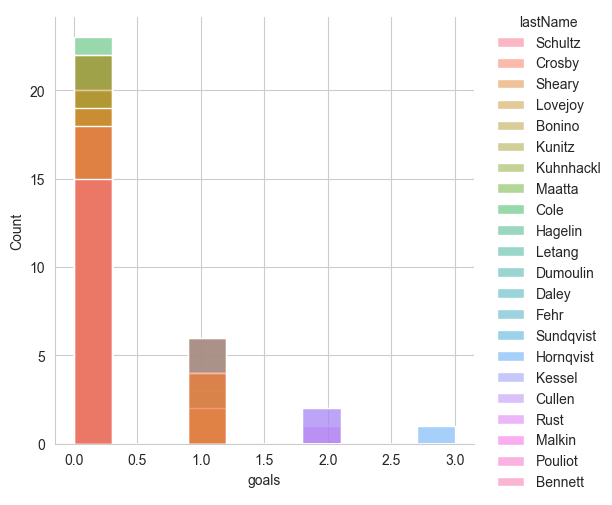

In [250]:
sns.displot(data=pens_201516_playoff_skater_stats_df, x='goals', hue='lastName')
plt.show()

In [237]:
kessel_stats_df = pens_201516_playoff_skater_stats_df[pens_201516_playoff_skater_stats_df['lastName']=='Kessel']
kessel_stats_df.groupby('game_id').describe()


timeOnIce                                                      \
               count    mean std     min     25%     50%     75%     max   
game_id                                                                    
2015030141       1.0  1127.0 NaN  1127.0  1127.0  1127.0  1127.0  1127.0   
2015030142       1.0  1132.0 NaN  1132.0  1132.0  1132.0  1132.0  1132.0   
2015030143       1.0   940.0 NaN   940.0   940.0   940.0   940.0   940.0   
2015030144       1.0   914.0 NaN   914.0   914.0   914.0   914.0   914.0   
2015030145       1.0  1062.0 NaN  1062.0  1062.0  1062.0  1062.0  1062.0   
2015030221       1.0  1185.0 NaN  1185.0  1185.0  1185.0  1185.0  1185.0   
2015030222       1.0  1107.0 NaN  1107.0  1107.0  1107.0  1107.0  1107.0   
2015030223       1.0  1015.0 NaN  1015.0  1015.0  1015.0  1015.0  1015.0   
2015030224       1.0  1063.0 NaN  1063.0  1063.0  1063.0  1063.0  1063.0   
2015030225       1.0   992.0 NaN   992.0   992.0   992.0   992.0   992.0   
2015030226       1.0   806.0 NaN   806.0   806.0   806.0   806.0   806.0   
2015030311       1.0  1206.0 NaN  1206.0  1206.0  1206.0  1206.0  1206.0   
2015030312       1.0   887.0 NaN   887.0   887.0   887.0   887.0   887.0   
2015030313       1.0  1149.0 NaN  1149.0  1149.0  1149.0  1149.0  1149.0   
2015030314       1.0  1147.0 NaN  1147.0  1147.0  1147.0  1147.0  1147.0   
2015030315       1.0  1033.0 NaN  1033.0  1033.0  1033.0  1033.0  1033.0   
2015030316       1.0  1055.0 NaN  1055.0  1055.0  1055.0  1055.0  1055.0   
2015030317       1.0  1066.0 NaN  1066.0  1066.0  1066.0  1066.0  1066.0   
2015030411       1.0  1145.0 NaN  1145.0  1145.0  1145.0  1145.0  1145.0   
2015030412       1.0  1237.0 NaN  1237.0  1237.0  1237.0  1237.0  1237.0   
2015030413       1.0  1296.0 NaN  1296.0  1296.0  1296.0  1296.0  1296.0   
2015030414       1.0   918.0 NaN   918.0   918.0   918.0   918.0   918.0   
2015030415       1.0  1151.0 NaN  1151.0  1151.0  1151.0  1151.0  1151.0   
2015030416       1.0   974.0 NaN   974.0   974.0   974.0   974.0   974.0   

           assists       ... shortHandedTimeOnIce      powerPlayTimeOnIce  \
             count mean  ...                  75%  max              count   
game_id                  ...                                                
2015030141     1.0  1.0  ...                  0.0  0.0                1.0   
2015030142     1.0  0.0  ...                  0.0  0.0                1.0   
2015030143     1.0  1.0  ...                  0.0  0.0                1.0   
2015030144     1.0  0.0  ...                  0.0  0.0                1.0   
2015030145     1.0  1.0  ...                  0.0  0.0                1.0   
2015030221     1.0  1.0  ...                  0.0  0.0                1.0   
2015030222     1.0  0.0  ...                  0.0  0.0                1.0   
2015030223     1.0  1.0  ...                  0.0  0.0                1.0   
2015030224     1.0  0.0  ...                  0.0  0.0                1.0   
2015030225     1.0  1.0  ...                  0.0  0.0                1.0   
2015030226     1.0  1.0  ...                  0.0  0.0                1.0   
2015030311     1.0  1.0  ...                  0.0  0.0                1.0   
2015030312     1.0  0.0  ...                  0.0  0.0                1.0   
2015030313     1.0  1.0  ...                  0.0  0.0                1.0   
2015030314     1.0  0.0  ...                  0.0  0.0                1.0   
2015030315     1.0  0.0  ...                  0.0  0.0                1.0   
2015030316     1.0  0.0  ...                  0.0  0.0                1.0   
2015030317     1.0  0.0  ...                  1.0  1.0                1.0   
2015030411     1.0  0.0  ...                  0.0  0.0                1.0   
2015030412     1.0  0.0  ...                  0.0  0.0                1.0   
2015030413     1.0  0.0  ...                  0.0  0.0                1.0   
2015030414     1.0  2.0  ...                  0.0  0.0                1.0   
2015030415     1.0  1.0  ...     